In [1]:
# Load dataset from drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/colab_files/actions.csv")

df.head()  # check it loaded

Mounted at /content/drive


,Unnamed: 0,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name
0,0,2500089,1,2.763597,1659,9637,52.50,34.00,63.00,30.60,251700146.0,0,0,1,0,pass,success,foot
1,1,2500089,1,4.761353,1659,8351,63.00,30.60,64.05,10.20,251700147.0,0,0,1,1,pass,success,foot
2,2,2500089,1,5.533097,1659,9285,64.05,10.20,72.45,20.40,251700148.0,0,0,1,2,pass,success,foot
3,3,2500089,1,7.707561,1659,239411,72.45,20.40,35.70,19.04,251700161.0,0,0,1,3,pass,success,foot
4,4,2500089,1,11.614943,1659,9637,35.70,19.04,30.45,12.24,251700149.0,0,0,1,4,pass,success,foot


In [2]:
# Make sure packages are installed
!pip install --quiet networkx matplotlib torch_geometric
!pip install --quiet torch torchvision torchaudio
!pip install --quiet scikit-learn

# python imports
import os
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import networkx as nx

from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, BatchNorm

# device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.1 MB/s eta 0:00:00
Device: cuda


In [ ]:
actions = pd.read_csv("/content/drive/MyDrive/kaggle_data/soccer_data/actions.csv")

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd

def build_action_graph(actions, spatial_thresh=10, temporal_thresh=5, connect_consecutive=True):
    """Builds a spatio-temporal graph from SPADL actions in a single match."""
    G = nx.Graph()
    actions = actions.copy()

    # --- Normalize time per half ---
    actions['time_norm'] = actions.groupby(['game_id', 'period_id'])['time_seconds'].transform(
        lambda x: x / x.max()
    )

    # --- Normalize positions to [0, 1] field coordinates ---
    actions['x_norm'] = actions['start_x'] / 105.0
    actions['y_norm'] = actions['start_y'] / 68.0
    actions['end_x_norm'] = actions['end_x'] / 105.0
    actions['end_y_norm'] = actions['end_y'] / 68.0

    # --- Derived features ---
    actions['dx_norm'] = actions['end_x_norm'] - actions['x_norm']
    actions['dy_norm'] = actions['end_y_norm'] - actions['y_norm']
    actions['dist_norm'] = np.sqrt(actions['dx_norm']**2 + actions['dy_norm']**2)

    # --- Add nodes ---
    for _, row in actions.iterrows():
        G.add_node(
            row['action_id'],
            player=row['player_id'],
            team=row['team_id'],
            game=row['game_id'],
            x=row['x_norm'],
            y=row['y_norm'],
            end_x=row['end_x_norm'],
            end_y=row['end_y_norm'],
            dx=row['dx_norm'],
            dy=row['dy_norm'],
            distance=row['dist_norm'],
            time=row['time_norm'],
            period=row['period_id'],
            result=row['result_id'],
            body_part=row['bodypart_id']
        )

    # --- Spatio-temporal edges ---
    coords = actions[['action_id', 'team_id', 'start_x', 'start_y', 'time_seconds']].to_numpy()
    for i in range(len(coords)):
        id_i, team_i, xi, yi, ti = coords[i]
        for j in range(i + 1, len(coords)):
            id_j, team_j, xj, yj, tj = coords[j]
            spatial = np.sqrt((xi - xj)**2 + (yi - yj)**2)
            temporal = abs(ti - tj)
            if spatial < spatial_thresh and temporal < temporal_thresh:
                edge_type = 'spatio-temporal-same' if team_i == team_j else 'spatio-temporal-diff'
                G.add_edge(id_i, id_j, type=edge_type)

    # --- Consecutive edges (sequence continuity) ---
    if connect_consecutive:
        for i in range(len(actions) - 1):
            if actions.iloc[i]['game_id'] == actions.iloc[i + 1]['game_id']:
                id_i = actions.iloc[i]['action_id']
                id_j = actions.iloc[i + 1]['action_id']
                G.add_edge(id_i, id_j, type='consecutive')

    return G

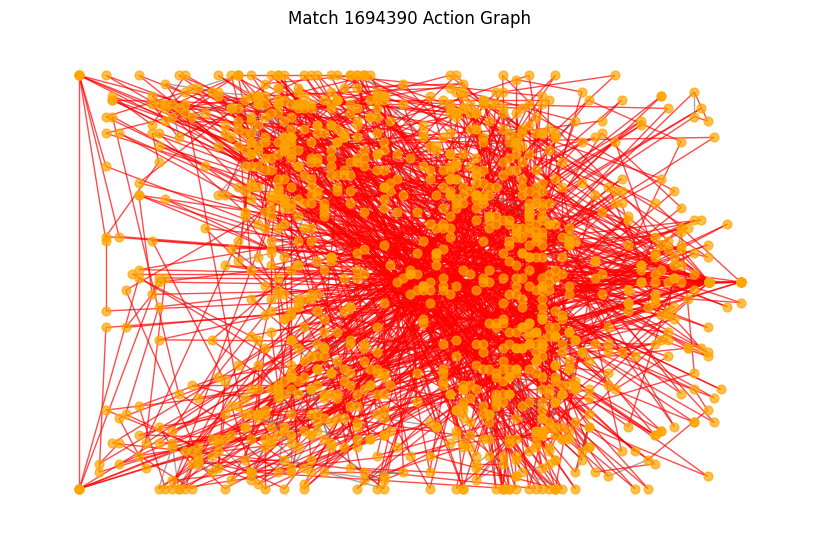

In [ ]:
import matplotlib.pyplot as plt

def visualize_action_graph(G, actions, title="Action Graph"):
    # The 'x_norm' and 'y_norm' are stored as 'x' and 'y' attributes in the graph nodes
    pos = {node_id: (G.nodes[node_id]['x'], G.nodes[node_id]['y']) for node_id in G.nodes()}
    edge_colors = ['red' if 'consecutive' in d['type'] else
                   'blue' if 'same_team' in d['type'] else
                   'gray' for _, _, d in G.edges(data=True)]

    plt.figure(figsize=(8, 5))
    nx.draw(
        G,
        pos,
        node_size=40,
        node_color='orange',
        edge_color=edge_colors,
        with_labels=False,
        alpha=0.7
    )
    plt.gca().invert_yaxis()  # Match soccer field convention
    plt.title(title)
    plt.show()

match_id = 1694390
match_actions = actions[actions['game_id'] == match_id]
G = build_action_graph(match_actions)
visualize_action_graph(G, match_actions, title=f"Match {match_id} Action Graph")

In [3]:
# Convert to pyG Data
import torch
from torch_geometric.data import Data
import networkx as nx
import numpy as np
import numpy as np
import torch
from torch_geometric.data import Data

def fast_graph_from_actions(actions, type_to_idx,
                            spatial_thresh=10, temporal_thresh=5,
                            connect_consecutive=True):
    """Fast vectorized version to create Data."""

    actions = actions.sort_values('time_seconds').reset_index(drop=True)

    # --- Normalized features ---
    actions['time_norm'] = actions.groupby('period_id')['time_seconds'].transform(lambda x: x / x.max())
    actions['x_norm'] = actions['start_x'] / 105.0
    actions['y_norm'] = actions['start_y'] / 68.0
    actions['end_x_norm'] = actions['end_x'] / 105.0
    actions['end_y_norm'] = actions['end_y'] / 68.0
    actions['dx_norm'] = actions['end_x_norm'] - actions['x_norm']
    actions['dy_norm'] = actions['end_y_norm'] - actions['y_norm']
    actions['dist_norm'] = np.sqrt(actions['dx_norm']**2 + actions['dy_norm']**2)

    N = len(actions)
    ids = actions['action_id'].to_numpy()
    team_ids = actions['team_id'].to_numpy()
    x = actions['start_x'].to_numpy()
    y = actions['start_y'].to_numpy()
    t = actions['time_seconds'].to_numpy()

    # --- Spatio-temporal adjacency (vectorized) ---
    dx = x[:, None] - x[None, :]
    dy = y[:, None] - y[None, :]
    dt = np.abs(t[:, None] - t[None, :])
    spatial = np.sqrt(dx**2 + dy**2)

    mask = (spatial < spatial_thresh) & (dt < temporal_thresh)
    np.fill_diagonal(mask, False)  # remove self-loops

    src, dst = np.where(mask)

    # --- Consecutive edges ---
    if connect_consecutive and N > 1:
        src_seq = np.arange(N - 1)
        dst_seq = np.arange(1, N)
        src = np.concatenate([src, src_seq])
        dst = np.concatenate([dst, dst_seq])

    edge_index = torch.tensor(np.vstack([src, dst]), dtype=torch.long)

    # --- Build features ---
    feat_cols = [
        'x_norm', 'y_norm', 'end_x_norm', 'end_y_norm',
        'dx_norm', 'dy_norm', 'dist_norm',
        'time_norm', 'result_id', 'bodypart_id', 'period_id'
    ]
    feat_tensor = torch.tensor(actions[feat_cols].to_numpy(), dtype=torch.float)

    # --- Next-action label ---
    next_types = actions['type_name'].shift(-1).map(type_to_idx).fillna(-100).astype(int)
    y_tensor = torch.tensor(next_types.to_numpy(), dtype=torch.long)

    return Data(x=feat_tensor, edge_index=edge_index, y=y_tensor)

# Build type mapping once
type_to_idx = {t: i for i, t in enumerate(sorted(df['type_name'].unique()))}

data_list = []
for gid, group in df.groupby('game_id'):
    data = fast_graph_from_actions(group, type_to_idx)
    data_list.append(data)

print("Built", len(data_list), "graphs.")

Built 1941 graphs.


In [4]:
# Shuffle + split
np.random.seed(42)
idxs = np.random.permutation(len(data_list))
train_end = int(0.7 * len(data_list))
val_end = int(0.85 * len(data_list))
train = [data_list[i] for i in idxs[:train_end]]
val   = [data_list[i] for i in idxs[train_end:val_end]]
test  = [data_list[i] for i in idxs[val_end:]]

batch_size = 8
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)



In [12]:
class SimpleGAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.5):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels // heads, heads=heads, concat=True)
        self.bn1 = BatchNorm(hidden_channels)
        self.gat2 = GATConv(hidden_channels, hidden_channels // heads, heads=heads, concat=True)
        self.bn2 = BatchNorm(hidden_channels)
        self.lin_skip = nn.Linear(in_channels, hidden_channels)
        self.lin_out = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x_skip = self.lin_skip(x)
        x = self.gat1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x + x_skip)

        x_skip = x
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x + x_skip)

        x = F.dropout(x, p=self.dropout, training=self.training)
        logits = self.lin_out(x)
        return logits


# hyperparams
in_dim = 11
hidden_dim = 128
num_heads = 8
out_dim = len(type_to_idx)
dropout = 0.3

model = SimpleGAT(in_dim, hidden_dim, out_dim, heads=num_heads, dropout=dropout).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.7,        # reduce LR by 30% when val loss plateaus
    patience=3         # wait 3 epochs before reducing
)

# fix class imbalance (passes dominate) by using weighted loss
from sklearn.utils.class_weight import compute_class_weight


# collect all labels
all_labels = torch.cat([d.y for d in train])
mask = all_labels != -100
classes = all_labels[mask].cpu().numpy()

# compute inverse-frequency weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(classes),
                                     y=classes)
weights = torch.tensor(class_weights, dtype=torch.float, device=DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=-100) #, weight=weights)

In [16]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_nodes = 0
    for batch in loader:
        batch = batch.to(DEVICE)
        optimizer.zero_grad()
        logits = model(batch.x, batch.edge_index)
        loss = criterion(logits, batch.y)
        (loss / batch.num_nodes).backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_nodes
        total_nodes += batch.num_nodes
    return total_loss / total_nodes

from sklearn.metrics import balanced_accuracy_score

@torch.no_grad()
def balanced_acc(y_true, y_pred):
    """Compute balanced accuracy ignoring masked (-100) labels."""
    mask = y_true != -100
    if mask.sum() == 0:
        return 0.0
    y_true = y_true[mask].cpu().numpy()
    y_pred = y_pred[mask].cpu().numpy()
    return balanced_accuracy_score(y_true, y_pred)

from sklearn.metrics import f1_score, top_k_accuracy_score, classification_report
import matplotlib.pyplot as plt

def evaluate(model, loader, criterion, k=3, type_to_idx=None):
    """Compute loss, accuracy, top-k accuracy, macro F1, and per-class F1."""
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    all_probs = []

    with torch.no_grad():
        for data in loader:
            data = data.to(DEVICE)
            out = model(data.x, data.edge_index)
            mask = data.y != -100
            y_true = data.y[mask]
            y_pred_masked = out[mask]

            loss = criterion(y_pred_masked, y_true)
            total_loss += loss.item()

            preds = y_pred_masked.argmax(dim=1)
            correct += (preds == y_true).sum().item()
            total += y_true.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_true.cpu().numpy())
            all_probs.extend(torch.softmax(y_pred_masked, dim=1).cpu().numpy())


    acc = correct / total
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_per_class = f1_score(all_labels, all_preds, average=None)

    # compute top-k accuracy
    num_classes = y_pred_masked.shape[1]
    if k <= num_classes:
        topk = top_k_accuracy_score(all_labels, np.array(all_probs), k=k)
    else:
        topk = None

    # optionally print per-class F1s
    #if type_to_idx is not None:
    #    idx_to_type = {v: k for k, v in type_to_idx.items()}
    #    print("\nPer-class F1:")
    #    for i, f1c in enumerate(f1_per_class):
    #        print(f"  {idx_to_type.get(i, str(i)):<20} : {f1c:.3f}")

    return total_loss / len(loader), acc, f1_macro, f1_per_class, topk

num_epochs = 60
train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_f1s, val_topk = [], []
val_f1s_per_class = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss, total_correct, total_examples = 0, 0, 0

    for data in train_loader:
        data = data.to(DEVICE)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        mask = data.y != -100
        loss = criterion(out[mask], data.y[mask])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = out[mask].argmax(dim=1)
        total_correct += (preds == data.y[mask]).sum().item()
        total_examples += data.y[mask].size(0)

    train_acc = total_correct / total_examples
    train_losses.append(total_loss / len(train_loader))
    train_accs.append(train_acc)

    # --- Validation ---
    val_loss, val_acc, val_f1, val_f1_class, val_topk_acc = evaluate(
        model, val_loader, criterion, k=3, type_to_idx=type_to_idx
    )

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)
    val_topk.append(val_topk_acc)
    val_f1s_per_class.append(val_f1_class)

    scheduler.step(val_loss)

    if epoch % 10 == 0:
      print(f"Epoch {epoch:02d} | "
            f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f} | "
            f"Macro F1: {val_f1:.3f} | Top-3 Acc: {val_topk_acc:.3f} | "
            f"Val Loss: {val_loss:.3f}")


Per-class F1:
  bad_touch            : 0.000
  clearance            : 0.133
  corner_crossed       : 0.000
  corner_short         : 0.000
  cross                : 0.027
  dribble              : 0.000
  foul                 : 0.000
  freekick_crossed     : 0.000
  freekick_short       : 0.011
  goalkick             : 0.005
  interception         : 0.300
  keeper_save          : 0.153
  pass                 : 0.809
  shot                 : 0.040
  shot_freekick        : 0.000
  shot_penalty         : 0.000
  tackle               : 0.000
  take_on              : 0.000
  throw_in             : 0.105

Per-class F1:
  bad_touch            : 0.000
  clearance            : 0.151
  corner_crossed       : 0.000
  corner_short         : 0.000
  cross                : 0.032
  dribble              : 0.000
  foul                 : 0.000
  freekick_crossed     : 0.000
  freekick_short       : 0.014
  goalkick             : 0.002
  interception         : 0.316
  keeper_save          : 0.143
  pass   

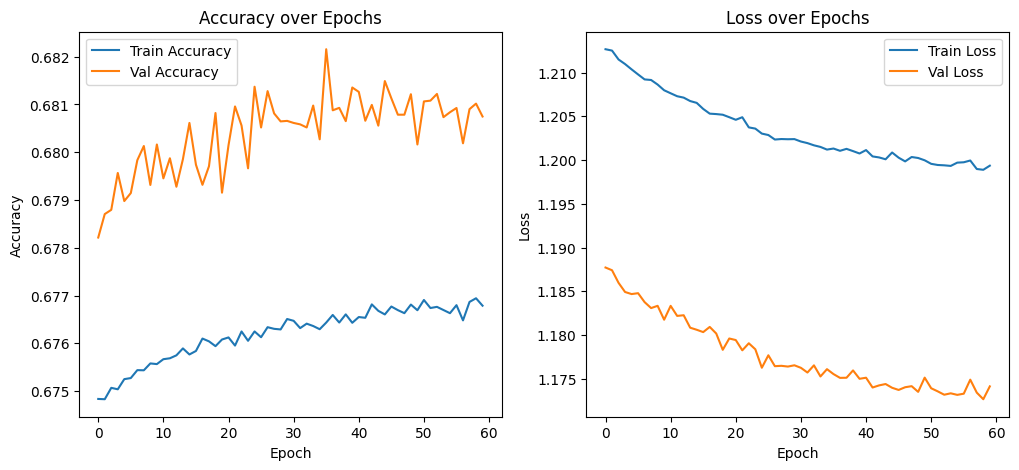

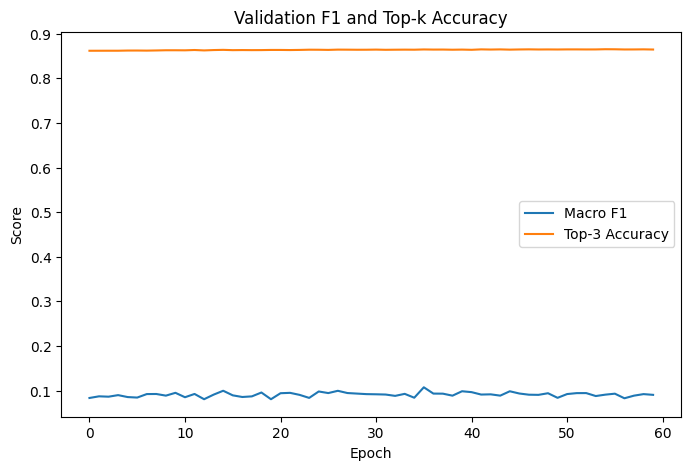

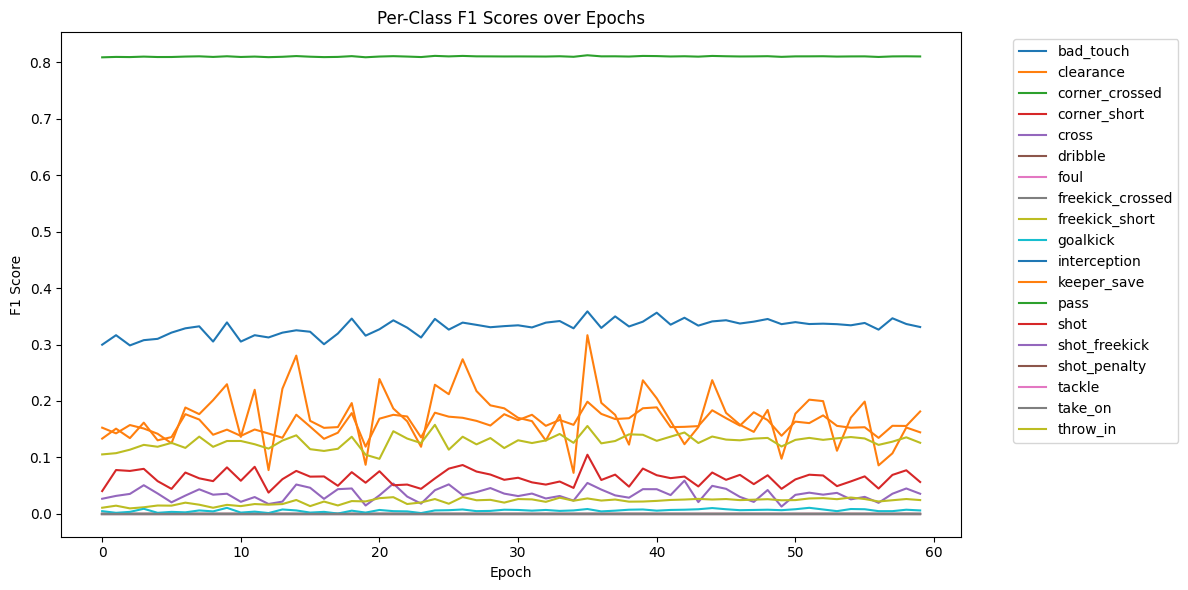


Best epoch: 36
Val Accuracy: 0.682
Macro F1: 0.107
Top-3 Accuracy: 0.865

Best per-class F1:
  bad_touch           : 0.000
  clearance           : 0.199
  corner_crossed      : 0.000
  corner_short        : 0.000
  cross               : 0.055
  dribble             : 0.000
  foul                : 0.000
  freekick_crossed    : 0.000
  freekick_short      : 0.027
  goalkick            : 0.008
  interception        : 0.359
  keeper_save         : 0.316
  pass                : 0.813
  shot                : 0.105
  shot_freekick       : 0.000
  shot_penalty        : 0.000
  tackle              : 0.000
  take_on             : 0.000
  throw_in            : 0.156


In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(8,5))
plt.plot(val_f1s, label='Macro F1')
plt.plot(val_topk, label='Top-3 Accuracy')
plt.title('Validation F1 and Top-k Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.show()

import numpy as np

val_f1s_per_class = np.array(val_f1s_per_class)  # shape: [epochs, num_classes]
idx_to_type = {v: k for k, v in type_to_idx.items()}

plt.figure(figsize=(12,6))
for i, action_name in idx_to_type.items():
    plt.plot(val_f1s_per_class[:, i], label=action_name)
plt.title('Per-Class F1 Scores over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

best_epoch = np.argmax(val_accs)
print(f"\nBest epoch: {best_epoch+1}")
print(f"Val Accuracy: {val_accs[best_epoch]:.3f}")
print(f"Macro F1: {val_f1s[best_epoch]:.3f}")
print(f"Top-3 Accuracy: {val_topk[best_epoch]:.3f}")
print("\nBest per-class F1:")
for action_name, f1_value in zip(idx_to_type.values(), val_f1s_per_class[best_epoch]):
    print(f"  {action_name:<20}: {f1_value:.3f}")
